## import libraries

In [2]:
!pip install -e ../

Obtaining file:///mnt/data/projects/wankun01/playground/cv/ViT-PyTorch
  Attempting uninstall: pytorch-pretrained-vit
    Found existing installation: pytorch-pretrained-vit 0.0.7
    Can't uninstall 'pytorch-pretrained-vit'. No files were found to uninstall.
  Running setup.py develop for pytorch-pretrained-vit


In [3]:
import os, sys, shutil, json
from pytorch_pretrained_vit import ViT
from torchsummary import summary
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import pandas as pd

## flow control

In [4]:
summarize_model = False
show_image_example = True
import torch
torch.manual_seed(42)
# regenerate_traffic_data = False

## set up device and load pretrained model

In [5]:
device = torch.device("cuda:0") if torch.cuda.is_available() == True else torch.device("cpu")
print("Using device:", device)
model = ViT("B_16_imagenet1k", pretrained=True,
            representation_size=768,
            load_repr_layer=True,
           )
model.to(device)
if summarize_model:
    summary(model, input_size=(3,384,384)) # must be 384 for B_16

Using device: cuda:0
repr size None
None True
pre_logits_size 768
Loaded pretrained weights.


## create a small support dataset with predefined labels


In [6]:
# the classes in oki data could be: one-house area, centralized housing(masion etc), public(greenery) area
# first we try 3-way, 3-shot, meaning that we have three images for above classes.
nways = 3
nshots = 3
data_root = "../imgs"
public_set = ["zLW_BVRbb_Vi7qiI1bqvsw.jpg", "_dtiPwWJp7hGyjVzRvn-fQ.jpg", "0eiRArv0qPHxXulFxPCvcg.jpg"]
one_set = ["_V3fRyr4aQWC0cboxU00nQ.jpg", "1HDDK4WHB3ZSHFfI1eyxqg.jpg", "6e9BZHBr7hHw6ukme2Tsfg.jpg"]
center_set = ["1UbKSUbcZ1WWtXqTBktP9w.jpg", "2imsDO2BncseuhMbCYe6Ag.jpg", "2ZzmVyV9HsqIDgfa5lS1eA.jpg"]
parking_set = ["B51xrhfEyaVA6vKQ8VjqZA.jpg", "B5EqDOgu4bpu37ilijjRYQ.jpg", "bFXPZ0zz-RbysCcWDfnpQQ.jpg"]

ground_truth = {0:"public greenary", 1:"one housing", 2:"centerized housing", 3:"parking lot"}
dataset_lst = [public_set, one_set, center_set, parking_set]

In [7]:
# define transforms
tsfm = transforms.Compose([transforms.Resize(model.image_size), 
                               transforms.ToTensor(), 
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                              ])

feature vector shape: torch.Size([1, 768])


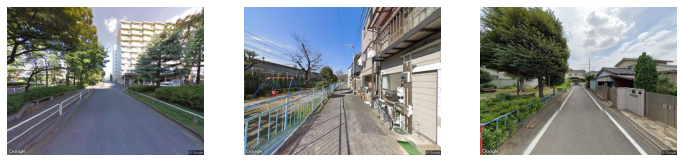

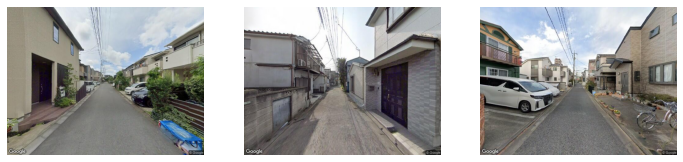

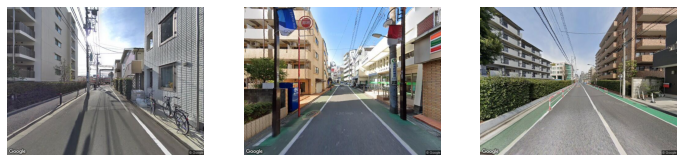

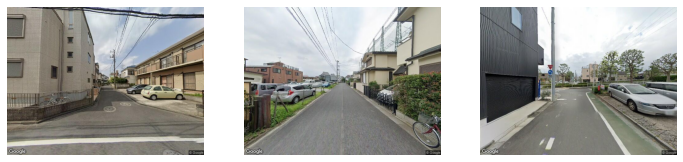

In [8]:
# now we use the pretrained model to extract the feature vectors of these imgs
model.eval() # set model to evaluate mode --> stop tracking gradients
representations = []
showsize = 128, 128
for dataset in dataset_lst:
    # for each type of the data, calculate the features mean first
    feature_vector = torch.tensor([0]*768, dtype=torch.float).to(device) # 768 dim
    fig = plt.figure(figsize=(12, 12))
    for i, shot in enumerate(dataset):
        img_path = os.path.join(data_root, shot)
        img = Image.open(img_path)
        a=fig.add_subplot(1,nshots,i+1)
        plt.imshow(img)
        plt.axis('off')
        # Preprocess image
        img = tsfm(img).unsqueeze(0)
        with torch.no_grad():
            outputs = model(img.to(device), logits=True).squeeze(0)
        # print(outputs.shape)
        feature_vector += outputs
    # print(feature_vector[0])
    feature_mean = 1/3 * feature_vector
    feature_mean_norm = F.normalize(feature_mean, dim=0)
    representations.append(feature_mean_norm.unsqueeze(0))

    # print(feature_mean_norm.shape)
    # print(feature_vector[0], feature_mean[0], feature_mean_norm[0])
print("feature vector shape:", representations[0].shape)

In [9]:
# the representation_set is [public, one, center]
# now use the same model to extract the feature vector for new data.
def extract_feature_vector(img_path, show=False):
    # feature_vector = torch.tensor([0]*768, dtype=torch.float).to(device) # 768 dim
    img = Image.open(img_path)
    if show:
        fig = plt.figure(figsize=(6,6))
        fig.add_subplot(1,1,1)
        plt.imshow(img)
    # Preprocess image
    img = tsfm(img).unsqueeze(0)
    with torch.no_grad():
        outputs = model(img.to(device), logits=True).squeeze(0)
    return F.normalize(outputs, dim=0)

In [10]:
# test with an example img
nclasses = len(representations)
print("N Classes:", nclasses)
pmatrix = torch.empty(nclasses, 768)
pmatrix = torch.cat(representations, dim=0)

N Classes: 4


## get ready for finetuning with support set

In [11]:
# define finetune data --> support set
X = []
y = []
for i, dataset in enumerate(dataset_lst):
    for fn in dataset:
        img_path = os.path.join(data_root, fn)
        X.append(extract_feature_vector(img_path).unsqueeze(0))
        y.append(i) 
        
X = torch.cat(X, dim=0).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)
print(X.shape, y.shape)

torch.Size([12, 768]) torch.Size([12])


## init cls head with proper values and configure training options

In [12]:
# the first option is to not let pretrained model weights to float.
# p(x) = softmax(w*x+b) where x is the feature vector from the feature extraction.
fc_w = pmatrix.clone().detach().requires_grad_(True) # this is recommended from pytorch doc
fc_b = torch.zeros((1,fc_w.shape[0]), dtype=torch.float, requires_grad=True)
print(fc_w.requires_grad, fc_b.requires_grad, fc_w.shape, fc_b.shape)

# torch.sum(torch.special.entr(torch.tensor([1,2,3]))) # just a test

# construct loss fn with cross-entropy and entropy regularization
def cross_entropy_regularized(output, target):
    # entropy regularization = - sum Pi * log(Pi) for Pi is the prob. for i-th class.
    
    entr =  torch.mean(torch.tensor([torch.sum(torch.special.entr(nn.Softmax(dim=0)(p))) for p in output], requires_grad=True))
    return nn.CrossEntropyLoss()(output, target) + entr # todo: check if entr is affecting the BP
    
loss_fn = cross_entropy_regularized
# loss_fn = nn.CrossEntropyLoss()
# create a classification head with given init values
# from feature vector to 3 classes,not that we don't need softmax in torch here.
cls_head = nn.Linear(nclasses, 768)
# load the init values from the representation vectors
with torch.no_grad():
    cls_head.weight = nn.Parameter(fc_w.detach().clone())
    cls_head.bias = nn.Parameter(fc_b.detach().clone()) # --> use clone so only the values are passed into cls head
print(cls_head.bias)
print(cls_head.weight)
# construct optimizer
cls_head.to(device)
lr = 1e-1
optimizer = torch.optim.SGD(cls_head.parameters(), lr=lr)

True True torch.Size([4, 768]) torch.Size([1, 4])
Parameter containing:
tensor([[0., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([[ 0.0120, -0.0479,  0.0868,  ..., -0.0264, -0.0213, -0.0031],
        [ 0.0635, -0.0996,  0.0243,  ..., -0.0393, -0.0578,  0.0029],
        [ 0.0249, -0.0360,  0.0082,  ..., -0.0533, -0.0181,  0.0005],
        [ 0.0582, -0.1006,  0.0426,  ..., -0.0365, -0.0287, -0.0225]],
       device='cuda:0', requires_grad=True)


## training step (cls head only)

In [13]:
# training loop
# make sure data is on right device
print(X.device)
# set hyperparameters
n_epochs = 2000
for epoch in range(n_epochs):
    pred = cls_head(X)
    # print(pred.shape, y.shape)
    loss = loss_fn(pred, y)
    # reset autograd
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch:", epoch, "Loss:", loss.item())
    # print(pred.shape)

cuda:0
Epoch: 0 Loss: 2.6100335121154785
Epoch: 100 Loss: 2.318622350692749
Epoch: 200 Loss: 2.0675902366638184
Epoch: 300 Loss: 1.8535435199737549
Epoch: 400 Loss: 1.6721010208129883
Epoch: 500 Loss: 1.5183441638946533
Epoch: 600 Loss: 1.387587547302246
Epoch: 700 Loss: 1.2757552862167358
Epoch: 800 Loss: 1.1794639825820923
Epoch: 900 Loss: 1.0959675312042236
Epoch: 1000 Loss: 1.023056983947754
Epoch: 1100 Loss: 0.9589604139328003
Epoch: 1200 Loss: 0.9022521376609802
Epoch: 1300 Loss: 0.8517804741859436
Epoch: 1400 Loss: 0.8066089153289795
Epoch: 1500 Loss: 0.7659724354743958
Epoch: 1600 Loss: 0.7292399406433105
Epoch: 1700 Loss: 0.6958893537521362
Epoch: 1800 Loss: 0.6654845476150513
Epoch: 1900 Loss: 0.6376594305038452


In [14]:
# check the detach actually works, these two sets should be different
print(cls_head.bias)
print(cls_head.weight)
print(fc_b)
print(fc_w)

Parameter containing:
tensor([[ 0.5865,  0.1255, -0.5320, -0.1800]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[-0.2452,  0.2344,  0.6333,  ...,  0.2105,  0.0752,  0.0693],
        [ 0.2917, -0.4568, -0.1683,  ..., -0.0905, -0.4530,  0.1981],
        [-0.1713,  0.3941, -0.4321,  ..., -0.2720,  0.1456,  0.0579],
        [ 0.2834, -0.4558,  0.1290,  ..., -0.0034,  0.1063, -0.3477]],
       device='cuda:0', requires_grad=True)
tensor([[0., 0., 0., 0.]], requires_grad=True)
tensor([[ 0.0120, -0.0479,  0.0868,  ..., -0.0264, -0.0213, -0.0031],
        [ 0.0635, -0.0996,  0.0243,  ..., -0.0393, -0.0578,  0.0029],
        [ 0.0249, -0.0360,  0.0082,  ..., -0.0533, -0.0181,  0.0005],
        [ 0.0582, -0.1006,  0.0426,  ..., -0.0365, -0.0287, -0.0225]],
       device='cuda:0', requires_grad=True)


## define functions to test prediction results with no-finetuning, head-finetuning

In [15]:
# no finetuning
def make_fewshots_pred_noft(img_path, pmatrix=pmatrix):
    test_vector = extract_feature_vector(img_path, show=True)
    # print(pmatrix.shape)
    prediction = nn.Softmax(dim=0)(torch.matmul(pmatrix, test_vector))
    print("-"*20)
    print("prediction with no-finetuning")
    for key, value in ground_truth.items():
        print(f"{value}:{prediction[key]*100:.04f}%")
    print("-"*20)

In [16]:
# with cls_head finetuning
def make_fewshots_pred_ft(img_path):
    test_vector = extract_feature_vector(img_path, show=False)
    # print(pmatrix.shape)
    # prediction = nn.Softmax(dim=0)(torch.matmul(pmatrix, test_vector))
    prediction = nn.Softmax(dim=1)(cls_head(test_vector.unsqueeze(0))).squeeze()
    print("-"*20)
    print("prediction with head-finetuning")
    for key, value in ground_truth.items():
        print(f"{value}:{prediction[key]*100:.04f}%")

## finetuning with BP to the pretrained vit

In [17]:
# combine vit and cls head
# make a new model
class ViT_CLS_FT(nn.Module):
    def __init__(self, pretrained_vit_body, cls_head):
        super().__init__()
        self.vit_body = pretrained_vit_body
        self.cls_head = cls_head
        # make sure model is in train mode
        self.vit_body.train()
        self.cls_head.train() 
    def forward(self, x):
        # by default the vit body will require logits=True when forward to output the logits
        x = self.vit_body(x, logits=True) # b, dim
        # normalize input x
        x = F.normalize(x, dim=1) # b, dim --> this is a trick
        # normalize weights in cls head liner layers
        with torch.no_grad():
            self.cls_head.weight.div_(torch.norm(self.cls_head.weight, dim=1, keepdim=True)) #
        x = self.cls_head(x) # b, dim
        return x

# make a new vit
vit_ft = ViT("B_16_imagenet1k", pretrained=True,
            representation_size=768,
            load_repr_layer=True,
           )
vit_ft.to(device)
# make a new cls head with preset parameters
cls_head_ft = nn.Linear(nclasses, 768)
# load the init values from the representation vectors
with torch.no_grad():
    cls_head_ft.weight = nn.Parameter(fc_w.detach().clone())
    cls_head_ft.bias = nn.Parameter(fc_b.detach().clone())
print("init values for cls head:")
print(cls_head_ft.bias)
print(cls_head_ft.weight)
# make a combined model using above two
model_ft = ViT_CLS_FT(pretrained_vit_body=vit_ft, cls_head=cls_head_ft)
model_ft.to(device)
if False:
    summary(model_ft, input_size=(3,384,384))

repr size None
None True
pre_logits_size 768
Loaded pretrained weights.
init values for cls head:
Parameter containing:
tensor([[0., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([[ 0.0120, -0.0479,  0.0868,  ..., -0.0264, -0.0213, -0.0031],
        [ 0.0635, -0.0996,  0.0243,  ..., -0.0393, -0.0578,  0.0029],
        [ 0.0249, -0.0360,  0.0082,  ..., -0.0533, -0.0181,  0.0005],
        [ 0.0582, -0.1006,  0.0426,  ..., -0.0365, -0.0287, -0.0225]],
       device='cuda:0', requires_grad=True)


In [20]:
# training loop --> finetuning the whole combined model
# define finetune data --> support set
X = []
y = []
for i, dataset in enumerate(dataset_lst):
    for fn in dataset:
        img_path = os.path.join(data_root, fn)
        img = Image.open(img_path)
        # Preprocess image
        img = tsfm(img).unsqueeze(0)
        X.append(img)
        y.append(i) 
        
X = torch.cat(X, dim=0).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)
print(X.shape, y.shape) # b, c, h, w

n_epochs = 100
lr = 1e-3
optimizer = torch.optim.AdamW(model_ft.parameters(), lr=lr)
for epoch in range(n_epochs):
    pred = model_ft(X)
    # print(pred.shape, y.shape)
    loss = loss_fn(pred, y)
    # reset autograd
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch:", epoch, "Loss:", loss.item())
    # print(pred.shape)

torch.Size([12, 3, 384, 384]) torch.Size([12])
Epoch: 0 Loss: 1.866292953491211
Epoch: 10 Loss: 1.8887779712677002
Epoch: 20 Loss: 1.8394864797592163
Epoch: 30 Loss: 1.8198976516723633
Epoch: 40 Loss: 1.8294661045074463
Epoch: 50 Loss: 1.79872465133667
Epoch: 60 Loss: 1.7913317680358887
Epoch: 70 Loss: 1.787632942199707
Epoch: 80 Loss: 1.7860019207000732
Epoch: 90 Loss: 1.784559726715088


## define function to test finetuned model (vit + mlp)

In [21]:
# with cls_head finetuning
def make_fewshots_pred_ft_all(img_path):
    # test_vector = extract_feature_vector(img_path, show=True)
    # print(pmatrix.shape)
    # prediction = nn.Softmax(dim=0)(torch.matmul(pmatrix, test_vector))
    img = Image.open(img_path)
    # Preprocess image
    img = tsfm(img).unsqueeze(0)
    prediction = nn.Softmax(dim=1)(model_ft(img.to(device))).squeeze(0)
    print("-"*20)
    print("prediction with \"vit + mlp\" finetuning")
    for key, value in ground_truth.items():
        print(f"{value}:{prediction[key]*100:.04f}%")
    print("-"*20)

## select any image to test results

In [32]:
test_img_path = os.path.join(data_root, "d3YcPZan5NUNUZmfKXu4TQ.jpg")

--------------------
prediction with no-finetuning
public greenary:22.8446%
one housing:24.9935%
centerized housing:24.2297%
parking lot:27.9322%
--------------------
--------------------
prediction with head-finetuning
public greenary:7.2262%
one housing:10.7951%
centerized housing:7.6971%
parking lot:74.2816%
--------------------
prediction with "vit + mlp" finetuning
public greenary:14.0530%
one housing:16.9503%
centerized housing:53.7768%
parking lot:15.2199%
--------------------


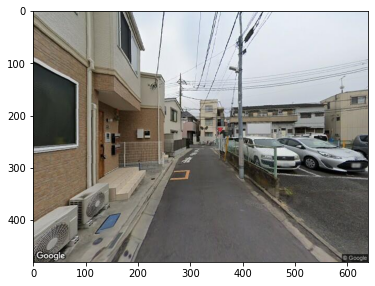

In [33]:
make_fewshots_pred_noft(test_img_path)
make_fewshots_pred_ft(test_img_path)
make_fewshots_pred_ft_all(test_img_path)

In [34]:
# save model parameters
model_ft_path = '../save_models/model_ft.pth'
cls_head_path = "../save_models/cls_head.pth"
torch.save(model_ft.state_dict(), model_ft_path)
torch.save(cls_head.state_dict(), cls_head_path)

## load true labels for the data

In [6]:
labels = pd.read_csv("/mnt/data/projects/wankun01/playground/cv/rawdata/annotations.csv")
labels = labels[["file_name", "category"]]
labels.head()


,file_name,category
0,000_0001.png,0
1,000_0002.png,0
2,000_0003.png,0
3,000_0010.png,0
4,000_0011.png,0


## load labels that model can predict

In [7]:
labels_map = json.load(open('../examples/simple/labels_map.txt'))
labels_map = [labels_map[str(i)] for i in range(1000)]
print(labels_map[0:5])

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark']


## perform single image prediction example

In [16]:
def make_single_prediction(img_path, model, device="cpu", show_image_example=False, feature_extraction=False):
    img = Image.open(img_path)
    if show_image_example:
        img.show()

    # Preprocess image
    tsfm = transforms.Compose([transforms.Resize(model.image_size), 
                               transforms.ToTensor(), 
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                              ])
    img = tsfm(img).unsqueeze(0)
    print("Image shape is:", img.shape)
    model.eval()
    if not feature_extraction:
        with torch.no_grad():
            outputs = model(img.to(device)).squeeze(0)
            print('-----')
            for idx in torch.topk(outputs, k=3).indices.tolist():
                prob = torch.softmax(outputs, -1)[idx].item()
                print('[{idx}] {label:<75} ({p:.2f}%)'.format(idx=idx, label=labels_map[idx], p=prob*100))
    else:
        with torch.no_grad():
            outputs = model(img.to(device), logits=True).squeeze(0)
            print('-----')
            print("Feature size:", outputs[0].shape)
            print("Feature vector from CLS token:", outputs[0])

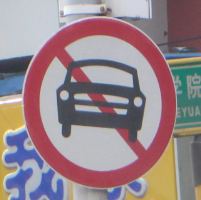

Image shape is: torch.Size([1, 3, 384, 384])
-----
[919] street sign                                                                 (84.90%)
[468] cab, hack, taxi, taxicab                                                    (3.44%)
[734] police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria     (1.86%)


In [17]:
make_single_prediction(train_files[12], model, device=device, show_image_example=show_image_example)

## try finetune on the train dataset

In [144]:
## create our dataset 
from  torch.utils.data import Dataset
class TrafficSignDataset(Dataset):
    pass

In [ ]:
model.train() # set to train mode, so all weights become trainable now.
tsfm = transforms.Compose([transforms.Resize(model.image_size), 
                               transforms.ToTensor(), 
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                              ])

for img in train_files:
    img = tsfm(img).unsqueeze(0)

## backup

## (optional) prepare traffic signs images into train and validation folders if needed

In [22]:
def prepare_traffic_train_val(root_path, targ_path, val_size=0.2, seed=42):
    files = glob(root_path)
    n_files = len(files)
    random.seed(seed)
    random.shuffle(files)
    os.makedirs(os.path.dirname(f"{targ_path}/train"), exist_ok=True)
    os.makedirs(os.path.dirname(f"{targ_path}/val"), exist_ok=True)
    # print(files)
    train_files, val_files = [], []
    for f in files[:int(n_files*(1-val_size))]:
        shutil.copy(f, f"{targ_path}/train")
        train_files.append(f)
    for f in files[int(n_files*(1-val_size)):]:
        shutil.copy(f, f"{targ_path}/val")
        val_files.append(f)
    return train_files, val_files

if regenerate_traffic_data:
    train_files, val_files = prepare_traffic_train_val("/mnt/data/projects/wankun01/playground/cv/rawdata/images/*", "/mnt/data/projects/wankun01/playground/cv/ViT-PyTorch/data")

In [ ]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_files):
    fig = figure()
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image,cmap='Greys_r')
        axis('off')